# Copernicus Atmosphere using ECMWFSearch plugin

In this tutorial we will show you how to use eodag to download data from providers using [ECMWFSearch](https://eodag.readthedocs.io/en/latest/plugins_reference/generated/eodag.plugins.search.build_search_result.ECMWFSearch.html) `eodag` plugin. You can currently find three providers that uses it, `cop_ads`, `cop_cds` and `cop_ewds`. For this tutorial we will use `cop_ads`, but `cop_cds` and `cop_ewds` are used the same way.

In [4]:
from eodag import EODataAccessGateway, setup_logging

setup_logging(1)  # 0: nothing, 1: only progress bars, 2: INFO, 3: DEBUG
dag = EODataAccessGateway()
dag.set_preferred_provider("cop_ads")

## Search (build download request)

There are two use case, a search for a product already configured in EODAG, or a search for a dataset not already configured, where you will have a little more to do.

We can add a `variable` (Temperature, `temperature`) and one `model_level` to the request because `CAMS_EAC4` is configured to request for some pre-configured values. Check the dataset available values to make your selection.

> Note: specifying your own variables will completely overwrite default values configured for `CAMS_EAC4` product type.

### Check available queryables and default values:

Available queryables parameters and associated values can be checked using [list_queryables()](https://eodag.readthedocs.io/en/latest/notebooks/api_user_guide/4_search.html#Queryables) method, or through [cop_ads](https://ads-beta.atmosphere.copernicus.eu/datasets/cams-global-reanalysis-eac4?tab=download) or [cop_cds](https://cds-beta.climate.copernicus.eu/datasets) websites:

In [5]:
queryables = dag.list_queryables(provider="cop_ads", productType="CAMS_EAC4")
queryables["variable"]

typing.Annotated[typing.Literal['10m_u_component_of_wind', '10m_v_component_of_wind', '2m_dewpoint_temperature', '2m_temperature', 'acetone', 'acetone_product', 'aldehydes', 'amine', 'ammonia', 'ammonium', 'black_carbon_aerosol_optical_depth_550nm', 'carbon_monoxide', 'dimethyl_sulfide', 'dinitrogen_pentoxide', 'dust_aerosol_0.03-0.55um_mixing_ratio', 'dust_aerosol_0.55-0.9um_mixing_ratio', 'dust_aerosol_0.9-20um_mixing_ratio', 'dust_aerosol_optical_depth_550nm', 'ethane', 'ethanol', 'ethene', 'formaldehyde', 'formic_acid', 'fraction_of_cloud_cover', 'geopotential', 'high_cloud_cover', 'high_vegetation_cover', 'hydrogen_peroxide', 'hydroperoxy_radical', 'hydrophilic_black_carbon_aerosol_mixing_ratio', 'hydrophilic_organic_matter_aerosol_mixing_ratio', 'hydrophobic_black_carbon_aerosol_mixing_ratio', 'hydrophobic_organic_matter_aerosol_mixing_ratio', 'hydroxyl_radical', 'isoprene', 'lake_cover', 'land_sea_mask', 'lead', 'leaf_area_index_high_vegetation', 'leaf_area_index_low_vegetation'

Here we can see the list of available values for `variable`, and that the default value configured for `CAMS_EAC4` is `2m_dewpoint_temperature`

### Search from an existing product type:

In [6]:
# Request for all parameters
products_from_product_type = dag.search(
    start="2021-01-01",
    end="2021-01-02",
    productType="CAMS_EAC4",
    count=True
)
print(
    "%s product built %s,\n having variable = %s\nand model_level=%s\n"
    % (
        products_from_product_type.number_matched,
        products_from_product_type[0],
        products_from_product_type[0].properties.get("variable"),
        products_from_product_type[0].properties.get("model_level"),
    )
)
# Request for temperature on one model level
products_from_product_type = dag.search(
    start="2021-01-01",
    end="2021-01-02",
    productType="CAMS_EAC4",
    variable="temperature",
    model_level="1",
    count=True
)
print(
    "%s product built %s,\n having variable = %s\nand model_level=%s\n"
    % (
        products_from_product_type.number_matched,
        products_from_product_type[0],
        products_from_product_type[0].properties.get("variable"),
        products_from_product_type[0].properties.get("model_level"),
    )
)

1 product built EOProduct(id=CAMS_EAC4_20210101_20210102_73a88c0f87e9dd6f77145167748b65ee4d1a757b, provider=cop_ads),
 having variable = 2m_dewpoint_temperature
and model_level=None

1 product built EOProduct(id=CAMS_EAC4_20210101_20210102_4d792734017419d1719b53f4d5b5d4d6888641de, provider=cop_ads),
 having variable = temperature
and model_level=1



### Search using a custom request:

Here we will use a set of custom parameters corresponding to `CAMS_EAC4`, which should result to the same request sent to ads.

In [7]:
ads_req_params = {
    "dataset": "cams-global-reanalysis-eac4",
    "variable": "temperature",
    "model_level": "1",
    "time": "00:00",
    "format": "grib",
}

products_from_ads_req = dag.search(
    provider="cop_ads",
    start="2021-01-01",
    end="2021-01-02",
    **ads_req_params,
)
# orderLink property must be the same with the two request methods,
# as they are built from the same ADS request arguments
if (
    products_from_ads_req[0].properties["orderLink"]
    == products_from_product_type[0].properties["orderLink"]
):
    print(
        "Request using productType or directly ADS parameters result to the\n",
        "same orderLink %s"
        % (
            products_from_ads_req[0].properties["orderLink"],
        )
    )

Request using productType or directly ADS parameters result to the
 same orderLink https://ads-beta.atmosphere.copernicus.eu/api/retrieve/v1/processes/cams-global-reanalysis-eac4/execution?{"inputs": {"data_format": "grib", "date": "2021-01-01/2021-01-02", "model_level": 1, "time": "00:00", "variable": "temperature"}}


### Send product retrieval request, download when available and return an `xarray.DataArray`

- download performed using ADS credentials set in `~/.config/eodag/eodag.yml` as for other EO providers:
```yaml
    cop_ads:
        priority:
        download:
            output_dir: /my/path/to/data/eodag_data
        auth:
            credentials:
                apikey: myapikey
```
- you can check your request status from https://ads-beta.atmosphere.copernicus.eu/requests?tab=all
- See [support](https://ads-beta.atmosphere.copernicus.eu/help) for any problem related to the provider

In [24]:
ds = products_from_ads_req[0].get_data(band=r"\.grib")

In [25]:
product = products_from_ads_req[0]
product.get_data(r"\.grib$")

<xarray.DataArray (band: 2, y: 241, x: 480)> Size: 2MB
[231360 values with dtype=float64]
Coordinates:
  * band         (band) int64 16B 1 2
  * x            (x) float64 4kB -180.0 -179.2 -178.5 ... 177.8 178.5 179.2
  * y            (y) float64 2kB 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
    spatial_ref  int64 8B 0
Attributes: (12/15)
    GRIB_UNIT:                           [C]
    GRIB_COMMENT:                        Temperature [C]
    GRIB_ELEMENT:                        TMP
    GRIB_SHORT_NAME:                     1-HYBL
    GRIB_REF_TIME:                       1609459200
    GRIB_VALID_TIME:                     1609459200
    ...                                  ...
    GRIB_PDS_PDTN:                       0
    GRIB_PDS_TEMPLATE_NUMBERS:           0 0 0 255 146 255 255 255 1 0 0 0 0 ...
    GRIB_PDS_TEMPLATE_ASSEMBLED_VALUES:  0 0 0 255 146 65535 255 1 0 105 0 1 ...
    scale_factor:                        1.0
    add_offset:                          0.0
    long_name:                           1[-] HYBL="Hybrid level"

### Plot using matplotlib

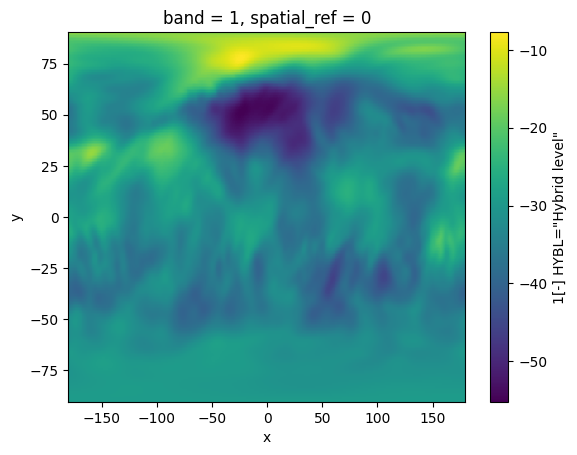

In [26]:
ds[0].plot()